In [1698]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import qmc    # quasi-Monte Carlo for latin hypercube sampling
from scipy.stats import mstats 
from scipy import stats as stats
from scipy.stats import rv_continuous
import scipy.optimize as opt

from scipy.stats import norm, weibull_min, beta


import warnings
warnings.filterwarnings("ignore")

N = 10 000                # random numbers to generate


SyntaxError: invalid syntax (<ipython-input-1698-d63479fb036f>, line 20)

In [ ]:
# Latin Hypercube LHS sampling of uniform random numbers

sampler = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
sample = sampler.random(n=10)
print(type(sampler))
sample

<class 'scipy.stats._qmc.LatinHypercube'>


array([[0.7226044 ],
       [0.05611216],
       [0.41414021],
       [0.2302632 ],
       [0.39058227],
       [0.50243776],
       [0.12388603],
       [0.82139357],
       [0.68718864],
       [0.95496141]])

In [ ]:
# quality of sample
qmc.discrepancy(sample)

0.001761364104473806

In [ ]:
# samples can be rescaled to fit between the defined bounds
seq = qmc.scale(sample, 0, 100)
print(type(seq))
seq

<class 'numpy.ndarray'>


array([[72.26043951],
       [ 5.6112156 ],
       [41.4140208 ],
       [23.02631971],
       [39.05822652],
       [50.24377648],
       [12.38860298],
       [82.13935695],
       [68.71886367],
       [95.49614062]])

In [ ]:
# define a new class pertm_gen: a generator for the PERT distribution

class pertm_gen(rv_continuous):
    '''modified beta_PERT distribution'''

 
    def _shape(self, min, mode, max, lmb):
        s_alpha = 1+ lmb*(mode - min)/(max-min)
        s_beta = 1 + lmb*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        z = (x - min) / (max - min)
        cdf = beta.cdf(z, s_alpha, s_beta)
        return cdf

    def _ppf(self, p, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        ppf = beta.ppf(p, s_alpha, s_beta)
        ppf = ppf * (max - min) + min
        return ppf


    def _mean(self, min, mode, max, lmb):
        mean = (min + lmb * mode + max) / (2 + lmb)
        return mean

    def _var(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = (mean - min) * (max - mean) / (lmb + 3)
        return var

    def _skew(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        skew1 = (min + max - 2*mean) / 4
        skew2 = (mean - min) * (max  - mean)
        skew2 = np.sqrt(7 / skew2)
        skew = skew1 * skew2
        return skew

    def _kurt(self, min, mode, max, lmb):
        a1,a2 = self._shape(min, mode, max, lmb)
        kurt1 = a1 + a2 +1
        kurt2 = 2 * (a1 + a2)**2
        kurt3 = a1 * a2 * (a1 + a2 - 6)
        kurt4 = a1 * a2 * (a1 + a2 + 2) * (a1 + a2 + 3)
        kurt5 = 3 * kurt1 * (kurt2 + kurt3)
        kurt = kurt5 / kurt4 -  3                 # scipy defines kurtosis of std normal distribution as 0 instead of 3
        return kurt

    def _stats(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = self._var(min, mode, max, lmb)
        skew = self._skew(min, mode, max, lmb)
        kurt = self._kurt(min, mode, max, lmb)
        return mean, var, skew, kurt


In [ ]:
# create a PERT instance 
min, mode, max, lmb = 10.0,20.0,40.0,4.0

# instantiate a PERT object
pertm = pertm_gen(name="pertm")
rvP = pertm(min,mode,max,lmb)

statsP = rvP.stats("mvsk")

moments = [np.asscalar(v) for v in statsP]
moment_names = ["mean", "var", "skew", "kurt"]
dict_moments = dict(zip(moment_names, moments))
_ = [print(k,":",f'{v:.2f}') for k,v in dict_moments.items()]

mean : 21.67
var : 30.56
skew : 0.30
kurt : -0.55


No handles with labels found to put in legend.


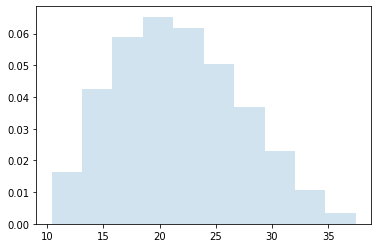

In [ ]:
# PERT random variates with LHS

sampler01 = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
sample01 = sampler01.random(n=N)

randP = rvP.ppf(sample01)

fig, ax = plt.subplots(1, 1)
ax.hist(randP, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


No handles with labels found to put in legend.


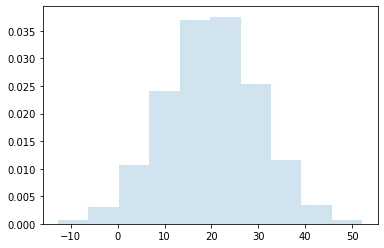

In [ ]:
# Normal random variates with LHS

sampler02 = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
sample02 = sampler02.random(n=N)

m, s = 20, 10
rvN = norm(m,s)
randN = rvN.ppf(sample02)

fig, ax = plt.subplots(1, 1)
ax.hist(randN, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


No handles with labels found to put in legend.


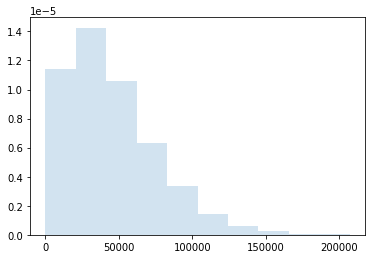

In [ ]:
# Weibull_Min random variates with LHS

sampler03 = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
sample03 = sampler03.random(n=N)

shp, loc, scl = 1.5, 0, 50000
rvW = weibull_min(shp, loc, scl)
randW = rvW.ppf(sample03)

fig, ax = plt.subplots(1, 1)
ax.hist(randW, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


In [ ]:
print(type(randW))

<class 'numpy.ndarray'>


In [ ]:
# generate 1000 normal random variates 

def wei_shp(mean,std):
    sampler = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
    sample = sampler.random(n=N)

    rv = norm(mean, std)
    rand = rv.ppf(sample)
    return rand

In [ ]:
# generate 1000 PERT random numbers

def wei_charlife(min,mode,max,lmb):
    sampler = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
    sample = sampler.random(n=N)
 
    pertm = pertm_gen(name="pertm")
    rv = pertm(min, mode, max, lmb)
    rand = rv.ppf(sample)
    return rand
    

No handles with labels found to put in legend.


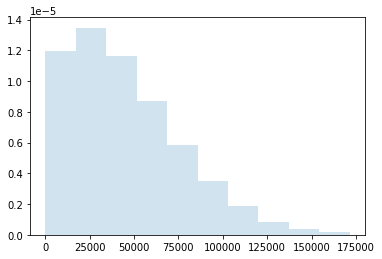

In [ ]:
# Weibull_Min random variates with LHS

sampler04 = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
sample04 = sampler04.random(n=N)

shp_m, shp_s = 1.5, 0.1   # weibull shape is normally distributed with mean m and std deviation s
loc = 0.0
scl_min, scl_mode, scl_max, scl_lmb = 45000, 50000, 60000, 8.0     # the weibull characteristic life is PERT-distributed

rand_CL = weibull_min.ppf(sample04, wei_shp(shp_m, shp_s), loc, wei_charlife(scl_min, scl_mode, scl_max, scl_lmb))


fig, ax = plt.subplots(1, 1)
ax.hist(rand_CL, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


In [ ]:
def dist_properties(data):

    # moments
    mean = data.mean()
    s = data.std()
    min = data.min()
    max = data.max()
    skew = np.asscalar(stats.skew(data))
    kurt = np.asscalar(stats.kurtosis(data))

    moment_names = ["mean", "std", "min", "max", "skew", "kurt"]
    moments = [mean,s,min,max,skew,kurt]
    dict_moments = dict(zip(moment_names, moments))
    _ = [print(k,":",f'{v:.3f}') for k,v in dict_moments.items()]


    # quantiles
    q1 = np.array([0.001, 0.01, 0.99, 0.999])
    q2 = np.arange(0.05, 0.95, 0.05)
    q = np.concatenate((q1,q2))
    q.sort()
    xq = np.quantile(data, q)
    
    qstr = [str(f'{v:.3f}') for v in q]
    dict_quantiles = dict(zip(qstr, xq))
    print("\nquantiles:")
    _ = [print(q,":",f'{xq:,.0f}') for q,xq in dict_quantiles.items()]


    # moments & quantiles
    metric_names = moment_names.extend(q)
    metrics = moments.extend(xq)
    dict_metrics = {**dict_moments, **dict_quantiles}
    return dict_metrics


In [ ]:
# properties of the simulation results

fixWeib = dist_properties(randW)
flexWeib = dist_properties(rand_CL)

print("\nCompare the Weibull with fixed parameters and the Weibull with stochastic parameters:")
pd.options.display.float_format = '{:,.3f}'.format
df = pd.DataFrame(index=range(len(fixWeib)))
df["metrics"] = fixWeib.keys()
df["fix Weibull"] = fixWeib.values()
df["flex Weibull"] = flexWeib.values()
df


mean : 45149.272
std : 30693.795
min : 101.349
max : 207072.532
skew : 1.086
kurt : 1.480

quantiles:
0.001 : 590
0.010 : 2,381
0.050 : 6,941
0.100 : 11,194
0.150 : 14,909
0.200 : 18,418
0.250 : 21,821
0.300 : 25,166
0.350 : 28,553
0.400 : 31,986
0.450 : 35,500
0.500 : 39,134
0.550 : 43,056
0.600 : 47,198
0.650 : 51,653
0.700 : 56,573
0.750 : 62,092
0.800 : 68,667
0.850 : 76,628
0.900 : 87,166
0.990 : 137,958
0.999 : 176,206
mean : 45162.291
std : 31294.437
min : 73.055
max : 171545.709
skew : 0.866
kurt : 0.464

quantiles:
0.001 : 185
0.010 : 1,333
0.050 : 5,119
0.100 : 9,270
0.150 : 13,156
0.200 : 16,871
0.250 : 20,496
0.300 : 24,155
0.350 : 27,817
0.400 : 31,577
0.450 : 35,413
0.500 : 39,472
0.550 : 43,676
0.600 : 48,108
0.650 : 52,922
0.700 : 58,119
0.750 : 63,998
0.800 : 70,685
0.850 : 78,732
0.900 : 89,027
0.990 : 133,709
0.999 : 160,356

Compare the Weibull with fixed parameters and the Weibull with stochastic parameters:


,metrics,fix Weibull,flex Weibull
0,mean,"45,149.272","45,162.291"
1,std,"30,693.795","31,294.437"
2,min,101.349,73.055
3,max,"207,072.532","171,545.709"
4,skew,1.086,0.866
5,kurt,1.480,0.464
6,0.001,590.213,185.289
7,0.010,"2,381.302","1,332.540"
8,0.050,"6,941.065","5,119.375"
9,0.100,"11,193.631","9,269.786"
